In [1]:
import scedar as sce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from collections import namedtuple
from collections import Counter

In [2]:
# plt.style.use('dark_background')
plt.style.use('default')
%matplotlib inline

## Read data

Zeisel: STRT-Seq. Mouse brain.

In [3]:
RealDataset = namedtuple('RealDataset',
                         ['id', 'x', 'coldata'])

In [4]:
%%time
zeisel = RealDataset(
    'Zeisel', 
    pd.read_csv('data/real_csvs/zeisel_counts.csv', index_col=0),
    pd.read_csv('data/real_csvs/zeisel_coldata.csv', index_col=0))

CPU times: user 5.31 s, sys: 549 ms, total: 5.86 s
Wall time: 5.87 s


## EDA

### Check dimensions and data

In [5]:
zeisel.x.shape

(19972, 3005)

In [6]:
zeisel.x.iloc[:3, :3]

,X1,X1.1,X1.2
Tspan12,0,0,0
Tshz1,3,1,0
Fnbp1l,3,1,6


In [7]:
zeisel.coldata.head()

,clust_id,cell_type1,total_features,log10_total_features,total_counts,log10_total_counts,pct_counts_top_50_features,pct_counts_top_100_features,pct_counts_top_200_features,pct_counts_top_500_features,...,log10_total_features_feature_control,total_counts_feature_control,log10_total_counts_feature_control,pct_counts_feature_control,total_features_ERCC,log10_total_features_ERCC,total_counts_ERCC,log10_total_counts_ERCC,pct_counts_ERCC,is_cell_control
X1,1,interneurons,4848,3.685652,21580,4.334072,19.819277,25.949954,34.147359,48.535681,...,0,0,0,0,0,0,0,0,0,False
X1.1,1,interneurons,4685,3.670802,21748,4.337439,19.293728,26.011587,34.715836,50.455214,...,0,0,0,0,0,0,0,0,0,False
X1.2,1,interneurons,6028,3.780245,31642,4.500278,17.423045,23.487769,31.369699,45.970545,...,0,0,0,0,0,0,0,0,0,False
X1.3,1,interneurons,5824,3.765296,32914,4.517394,19.593486,26.122623,34.687367,49.222215,...,0,0,0,0,0,0,0,0,0,False
X1.4,1,interneurons,4701,3.672283,21530,4.333064,15.397120,21.634928,30.380864,46.339991,...,0,0,0,0,0,0,0,0,0,False


In [8]:
labs = zeisel.coldata['cell_type1'].values.tolist()

In [9]:
Counter(labs).most_common()

[('ca1pyramidal', 948),
 ('oligodendrocytes', 820),
 ('s1pyramidal', 390),
 ('interneurons', 290),
 ('astrocytes', 198),
 ('endothelial', 175),
 ('microglia', 98),
 ('mural', 60),
 ('ependymal', 26)]

### Create an instance of scedar data structure

The `sce.eda.SampleDistanceMatrix` class stores the data matrix and distance matrix of a scRNA-seq dataset without cell type label. The distance matrix is computed only when necessary, which could also be directly provided by the user.

In [10]:
%%time
sdm = sce.eda.SampleDistanceMatrix(
    zeisel.x.values.T,
    fids=zeisel.x.index.values.tolist(),
    metric='cosine', nprocs=25)

CPU times: user 86.2 ms, sys: 140 ms, total: 226 ms
Wall time: 224 ms


### t-SNE

In [11]:
%%time
tsne_x = sdm.tsne(perplexity=30, n_iter=3000, random_state=111)

CPU times: user 3min 1s, sys: 1min 53s, total: 4min 54s
Wall time: 4min 14s


CPU times: user 44.7 ms, sys: 12.2 ms, total: 56.9 ms
Wall time: 51.8 ms


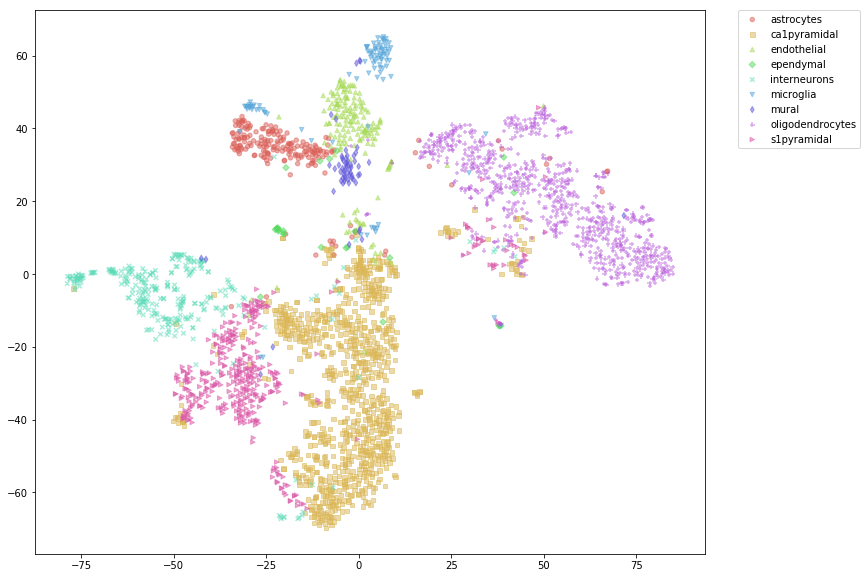

In [12]:
%%time
sdm.tsne_plot(labels=labs, figsize=(15, 10), alpha=0.5, s=20,
              n_txt_per_cluster=0, plot_different_markers=True,
              shuffle_label_colors=False, random_state=15)

### KNN graph

In [13]:
%%time
fig = sdm.s_knn_graph(k=2, labels=labs, alpha=0.3, node_size=10,
                      figsize=(15, 8), random_state=123)

CPU times: user 51.9 s, sys: 88.8 ms, total: 52 s
Wall time: 52.1 s


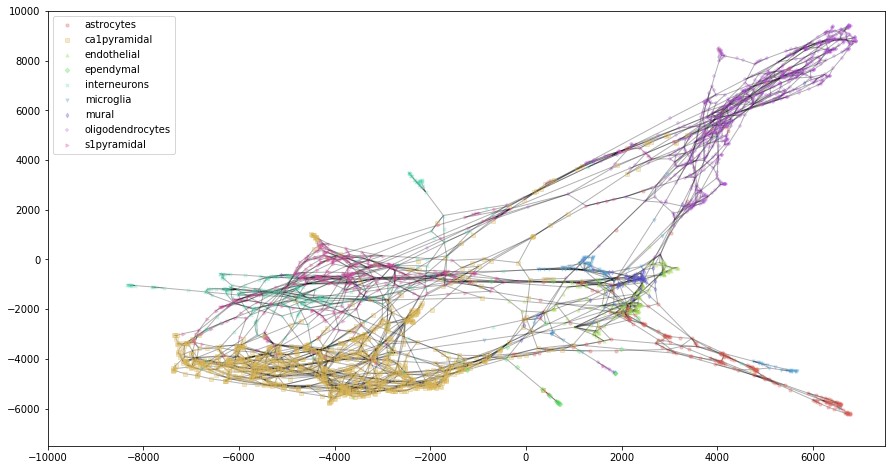

In [14]:
fig.get_axes()[0].set_xlim(-10000, 7500)
fig.get_axes()[0].set_ylim(-7500, 10000)
fig

## Clustering

In [15]:
%%time
mirac_res = sce.cluster.MIRAC(
    sdm._last_tsne, metric='euclidean',
    linkage='ward', min_cl_n=25,
    min_split_mdl_red_ratio=0.00,
    cl_mdl_scale_factor=0.8)

CPU times: user 10min 40s, sys: 9.21 s, total: 10min 49s
Wall time: 10min 40s


### Visualize pairwise distance matrix

In [16]:
# setup for pairwise distance matrix visualization
# this procedure will be simplified in future
# versions of scedar

# convert labels to random integers, in order
# to better visualize the pairwise distance
# matrix
np.random.seed(123)
uniq_labs = sorted(set(mirac_res.labs))
rand_lab_lut = dict(zip(uniq_labs,
                        np.random.choice(len(uniq_labs),
                                         size=len(uniq_labs),
                                         replace=False).tolist()))
olabs = mirac_res._labs
mirac_res._labs = [rand_lab_lut[l] for l in olabs]

# visualize the original cosine pairwise
# distance matrix rather than the t-SNE
# euclidean pairwise distance
tsne_euc_d = mirac_res._sdm._d
mirac_res._sdm._lazy_load_d = sdm._d

# order orignial cell types according to hac
# optimal ordering
mirac_res_ord_cell_types = [labs[i] for i in mirac_res._hac_tree.leaf_ids()]

CPU times: user 304 ms, sys: 60.7 ms, total: 365 ms
Wall time: 364 ms


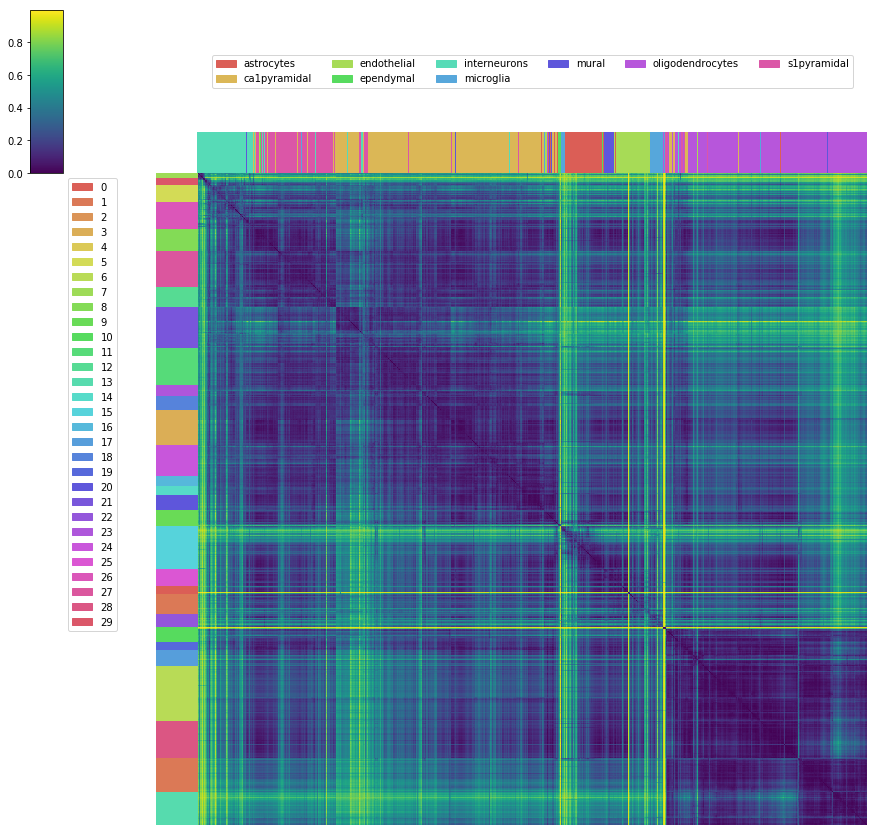

In [17]:
%%time
mirac_res.dmat_heatmap(col_labels=mirac_res_ord_cell_types,
                       figsize=(15, 15), cmap='viridis')

### Visualize t-SNE

In [18]:
slcs = sdm.to_classified(mirac_res.labs)

CPU times: user 85.7 ms, sys: 2.29 ms, total: 88 ms
Wall time: 83.5 ms


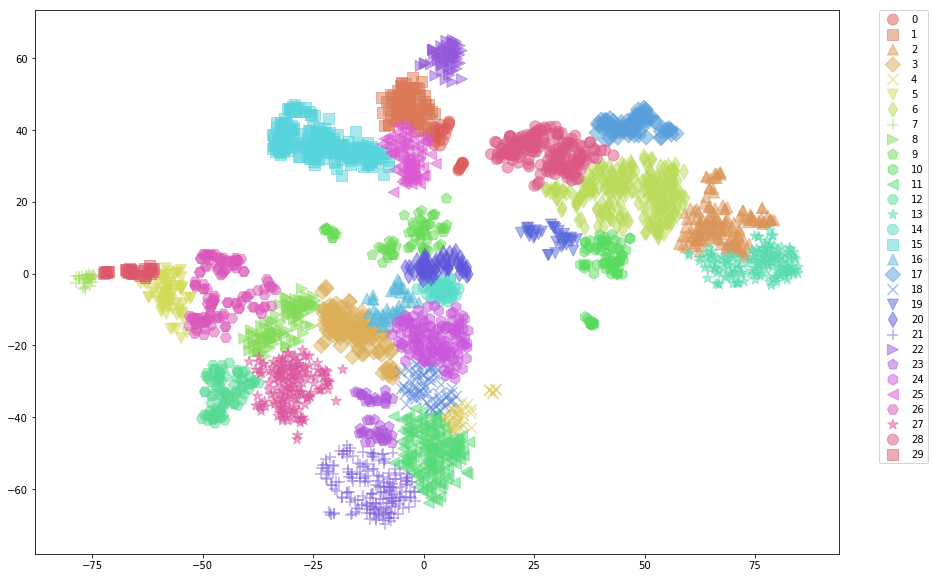

In [19]:
%%time
slcs.tsne_plot(figsize=(18, 10), alpha=0.5, s=120,
               n_txt_per_cluster=0, plot_different_markers=True,
               shuffle_label_colors=False, random_state=15)

### Identify cluster separating genes

In [20]:
cmp_labs = [1, 15, 22]

In [21]:
xgb_params = {"eta": 0.3,
              "max_depth": 1,
              "silent": 1,
              "nthread": 20,
              "alpha": 1,
              "lambda": 0,
              "seed": 123}

In [22]:
%%time
cmp_labs_sgs = slcs.feature_importance_across_labs(
    cmp_labs, nprocs=50, random_state=123, xgb_params=xgb_params,
    num_bootstrap_round=500, shuffle_features=True)

test rmse: mean 0.258679534, std 0.03678293230740456
train rmse: mean 0.211492116, std 0.022181110858936186
CPU times: user 15min 51s, sys: 2min 48s, total: 18min 39s
Wall time: 3min 12s


In [23]:
[t[:4] for t in cmp_labs_sgs[0][:15]]

[('Apoe', 1.4200913242009132, 0.5787389778175291, 438),
 ('Itm2a', 1.191891891891892, 0.40728393600638507, 370),
 ('Mrc1', 1.7095808383233533, 0.7317220712626823, 334),
 ('C1qb', 1.3665480427046264, 0.6119961842547977, 281),
 ('Cldn5', 1.124223602484472, 0.34815866974513093, 161),
 ('Sparc', 1.069182389937107, 0.25376403775889333, 159),
 ('Ccl24', 1.1578947368421053, 0.445817745949932, 152),
 ('Slc2a1', 1.006993006993007, 0.0833312957189719, 143),
 ('Fcgr3', 1.1428571428571428, 0.388613443106727, 140),
 ('Cst3', 1.0, 0.0, 118),
 ('Ptprb', 1.01, 0.09949874371066199, 100),
 ('Flt1', 1.0618556701030928, 0.24089322568140048, 97),
 ('F13a1', 1.4375, 0.5918280296392413, 96),
 ('Pf4', 1.3846153846153846, 0.6249260311258432, 91),
 ('Ctla2a', 1.0, 0.0, 80)]

In [24]:
sorted_cmp_labs_sgs = sorted(cmp_labs_sgs[0], key=lambda t: t[1], reverse=True)

In [25]:
[t[:4] for t in sorted_cmp_labs_sgs[:15]]

[('Mrc1', 1.7095808383233533, 0.7317220712626823, 334),
 ('F13a1', 1.4375, 0.5918280296392413, 96),
 ('Apoe', 1.4200913242009132, 0.5787389778175291, 438),
 ('Pf4', 1.3846153846153846, 0.6249260311258432, 91),
 ('C1qb', 1.3665480427046264, 0.6119961842547977, 281),
 ('Ms4a7', 1.3529411764705883, 0.6809315825170721, 17),
 ('Sepp1', 1.3333333333333333, 0.4714045207910317, 3),
 ('Dab2', 1.3333333333333333, 0.4714045207910317, 3),
 ('Cbr2', 1.2816901408450705, 0.585820685720716, 71),
 ('Ctsc', 1.25, 0.4330127018922193, 4),
 ('Fcrls', 1.2307692307692308, 0.4213250442347432, 13),
 ('Emr1', 1.2, 0.4000000000000001, 5),
 ('Itm2a', 1.191891891891892, 0.40728393600638507, 370),
 ('Ccl24', 1.1578947368421053, 0.445817745949932, 152),
 ('Fcgr3', 1.1428571428571428, 0.388613443106727, 140)]

In [26]:
len(sorted_cmp_labs_sgs)

148

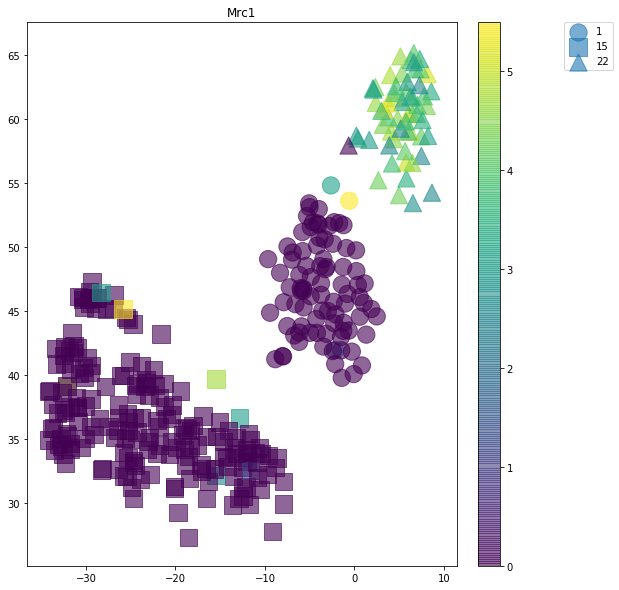

In [27]:
sgid = sorted_cmp_labs_sgs[0][0]
slcs.tsne_feature_gradient_plot(sgid, figsize=(11, 10), alpha=0.6, s=300,
                                selected_labels=cmp_labs,
                                transform=lambda x: np.log2(x+1),
                                title=sgid, n_txt_per_cluster=0,
                                plot_different_markers=True,
                                shuffle_label_colors=True, random_state=15)